# Arithmetic Coding for Grayscale Images (from scratch)

**No external libraries used.**

This notebook implements arithmetic coding end‑to‑end for 8‑bit grayscale images in the PGM (P5) format using only core Python. You can:

1. **Load** a PGM (P5) image using a pure‑Python parser
2. **Compress** it with a 32‑bit integer arithmetic coder (with E1/E2/E3 renormalization)
3. **Decompress** the bitstream back to the original image
4. **Verify** round‑trip correctness and see the compression ratio
5. **Save** the reconstructed image back to PGM

You can also generate a small **demo image** if you don't have a PGM file handy.

> **Format note**: This notebook supports **PGM P5 (binary)** images only. Max gray value must be ≤ 255.


In [1]:
from google.colab import files
uploaded = files.upload()   # choose your JPG file
jpg_filename = list(uploaded.keys())[0]


Saving Lenna.png to Lenna.png


In [4]:
from PIL import Image

# Open and convert to grayscale
img = Image.open(jpg_filename).convert("L")   # "L" = 8-bit grayscale
w, h = img.size
pixels = bytearray(img.tobytes())

# Save as PGM P5 so our arithmetic coder can use it
input_pgm_path = "Lenna.pgm"
with open(input_pgm_path, "wb") as f:
    f.write(f"P5\n{w} {h}\n255\n".encode())
    f.write(pixels)

print("Converted JPG to PGM:", input_pgm_path, f"({w}x{h})")


Converted JPG to PGM: Lenna.pgm (512x512)


## Helper: Minimal PGM (P5) Reader/Writer (Pure Python)

This section provides small functions to read/write PGM P5 files without any external packages.

In [5]:
# ------------------------
# PGM (P5) reader/writer
# ------------------------
def _pgm_read_tokens_and_rest(b):
    # Split header tokens (handling comments) and return (tokens, remaining_bytes)
    i = 0
    n = len(b)
    tokens = []
    token = bytearray()
    def flush():
        nonlocal token, tokens
        if token:
            tokens.append(bytes(token))
            token = bytearray()
    while i < n:
        c = b[i]
        if c == 35:  # '#': comment until end of line
            # skip to next \n
            while i < n and b[i] not in (10, 13):
                i += 1
        elif c in (9, 10, 13, 32):  # whitespace
            flush()
        else:
            token.append(c)
        # detect end of header once we have 4 tokens: P5, width, height, maxval
        if len(tokens) >= 4:
            # skip following single whitespace and break; the rest is pixel data
            # Ensure at least one whitespace consumed after maxval
            # Move i to the next non-whitespace position after the last token if needed
            j = i + 1
            while j < n and b[j] in (9, 10, 13, 32):
                j += 1
            return tokens, b[j:]
        i += 1
    flush()
    return tokens, b[i:]

def read_pgm_p5(path):
    with open(path, 'rb') as f:
        data = f.read()
    tokens, rest = _pgm_read_tokens_and_rest(data)
    if len(tokens) < 4:
        raise ValueError('Invalid PGM header')
    if tokens[0] != b'P5':
        raise ValueError('Only P5 (binary) PGM supported')
    width = int(tokens[1])
    height = int(tokens[2])
    maxval = int(tokens[3])
    if not (0 < width and 0 < height):
        raise ValueError('Invalid image dimensions')
    if not (0 < maxval <= 255):
        raise ValueError('Max gray value must be in 1..255')
    num_pixels = width * height
    if len(rest) < num_pixels:
        raise ValueError('File truncated: not enough pixel data')
    pixels = rest[:num_pixels]
    return width, height, maxval, bytearray(pixels)

def write_pgm_p5(path, width, height, maxval, pixels):
    if len(pixels) != width * height:
        raise ValueError('Pixel data length mismatch')
    header = f"P5\n{width} {height}\n{maxval}\n".encode('ascii')
    with open(path, 'wb') as f:
        f.write(header)
        f.write(bytes(pixels))
    return path

def make_demo_image(width=128, height=96):
    # Create a simple synthetic gradient + squares, 8-bit grayscale
    pixels = bytearray(width * height)
    for y in range(height):
        for x in range(width):
            v = (x * 255) // (width - 1)
            # add a few blocks
            if 16 < x < 48 and 16 < y < 48:
                v = (v // 2)
            if 64 < x < 112 and 40 < y < 80:
                v = 255 - v
            pixels[y*width + x] = v
    return width, height, 255, pixels


## Core: Arithmetic Coding (Integer, 32-bit)

We implement a classic arithmetic coder with **E1/E2/E3 renormalization** and a **static frequency model** built from the input data (with +1 smoothing to avoid zero probabilities). Alphabet is 0..256 where **256 is an EOF symbol**. No floating point is used.

In [6]:
# ------------------------
# Bit I/O helpers
# ------------------------
class BitWriter:
    def __init__(self):
        self.buf = bytearray()
        self.acc = 0
        self.bits = 0

    def write_bit(self, b):
        self.acc = (self.acc << 1) | (1 if b else 0)
        self.bits += 1
        if self.bits == 8:
            self.buf.append(self.acc & 0xFF)
            self.acc = 0
            self.bits = 0

    def write_bit_plus_follow(self, bit, follow):
        self.write_bit(bit)
        for _ in range(follow):
            self.write_bit(1 - bit)

    def flush(self):
        if self.bits != 0:
            self.buf.append((self.acc << (8 - self.bits)) & 0xFF)
            self.acc = 0
            self.bits = 0
        return bytes(self.buf)

class BitReader:
    def __init__(self, data):
        self.data = data
        self.i = 0
        self.acc = 0
        self.bits = 0

    def read_bit(self):
        if self.bits == 0:
            if self.i < len(self.data):
                self.acc = self.data[self.i]
                self.i += 1
                self.bits = 8
            else:
                # If no more data, return 0-bits (standard convention)
                return 0
        self.bits -= 1
        return (self.acc >> self.bits) & 1

# ------------------------
# Model helpers (static frequencies + cumulative)
# ------------------------
def build_frequencies(data_bytes):
    # Alphabet: 0..256 (EOF=256)
    freq = [1] * 257  # +1 smoothing
    for b in data_bytes:
        freq[b] += 1
    # EOF symbol
    freq[256] += 1
    total = 0
    cum = [0] * (len(freq) + 1)
    for i, f in enumerate(freq):
        cum[i] = total
        total += f
    cum[len(freq)] = total
    return freq, cum, total

# ------------------------
# Arithmetic Encoder/Decoder
# ------------------------
class ArithmeticCoder:
    def __init__(self):
        # Range is [low, high], inclusive, using 32-bit integers
        self.CODE_BITS = 32
        self.TOP_VALUE = (1 << self.CODE_BITS) - 1
        self.HALF = (self.TOP_VALUE + 1) >> 1
        self.FIRST_QTR = self.HALF >> 1
        self.THIRD_QTR = self.FIRST_QTR * 3

    def encode(self, symbols, cum, total):
        low = 0
        high = self.TOP_VALUE
        bits_to_follow = 0
        bw = BitWriter()

        for s in symbols:
            # Update range
            range_ = (high - low + 1)
            high = low + (range_ * cum[s + 1]) // total - 1
            low =  low + (range_ * cum[s])     // total

            # Renormalization (E1/E2/E3 conditions)
            while True:
                if high < self.HALF:
                    bw.write_bit_plus_follow(0, bits_to_follow)
                    bits_to_follow = 0
                    low = low * 2
                    high = high * 2 + 1
                elif low >= self.HALF:
                    bw.write_bit_plus_follow(1, bits_to_follow)
                    bits_to_follow = 0
                    low = (low - self.HALF) * 2
                    high = (high - self.HALF) * 2 + 1
                elif self.FIRST_QTR <= low and high < self.THIRD_QTR:
                    bits_to_follow += 1
                    low = (low - self.FIRST_QTR) * 2
                    high = (high - self.FIRST_QTR) * 2 + 1
                else:
                    break

        # Termination: push one more bit to distinguish interval
        bits_to_follow += 1
        if low < self.FIRST_QTR:
            bw.write_bit_plus_follow(0, bits_to_follow)
        else:
            bw.write_bit_plus_follow(1, bits_to_follow)
        return bw.flush()

    def decode(self, n_symbols, cum, total, bitstream):
        low = 0
        high = self.TOP_VALUE
        br = BitReader(bitstream)
        code = 0
        for _ in range(self.CODE_BITS):
            code = (code << 1) | br.read_bit()

        # Build a reverse lookup from cumulative intervals (linear search; keep simple)
        # cum[k] <= x < cum[k+1]
        out = []
        for _ in range(n_symbols):
            range_ = (high - low + 1)
            # scaled value in cumulative space
            value = ((code - low + 1) * total - 1) // range_
            # find symbol s.t. cum[s] <= value < cum[s+1]
            # linear search is fine for 257 symbols; can be optimized with binary search
            lo = 0
            hi = 257  # number of symbols (0..256)
            # binary search for speed
            while lo + 1 < hi:
                mid = (lo + hi) // 2
                if cum[mid] <= value:
                    lo = mid
                else:
                    hi = mid
            s = lo
            out.append(s)

            # Update interval for this symbol
            high = low + (range_ * cum[s + 1]) // total - 1
            low =  low + (range_ * cum[s])     // total

            # Renormalize
            while True:
                if high < self.HALF:
                    low = low * 2
                    high = high * 2 + 1
                    code = (code * 2) | br.read_bit()
                elif low >= self.HALF:
                    low = (low - self.HALF) * 2
                    high = (high - self.HALF) * 2 + 1
                    code = ((code - self.HALF) * 2) | br.read_bit()
                elif self.FIRST_QTR <= low and high < self.THIRD_QTR:
                    low = (low - self.FIRST_QTR) * 2
                    high = (high - self.FIRST_QTR) * 2 + 1
                    code = ((code - self.FIRST_QTR) * 2) | br.read_bit()
                else:
                    break
        return out


## End‑to‑End: Compress & Decompress an Image

Run the next cell to:
1. Generate a demo image (or set `use_demo=False` and provide a PGM path)
2. Build a static frequency model (with +1 smoothing)
3. Encode pixel bytes + EOF
4. Decode and verify exact match
5. Report compression stats and write the reconstructed image


In [7]:
## Configure here
use_demo = False                # Set to False to load your own PGM (P5)
input_pgm_path = 'Lenna.pgm'    # Used only if use_demo=False
recon_pgm_path = 'reconstructed.pgm'

# Load or create image
if use_demo:
    w, h, maxval, pixels = make_demo_image(160, 120)
else:
    w, h, maxval, pixels = read_pgm_p5(input_pgm_path)

print(f'Image: {w}x{h}, maxval={maxval}, pixels={len(pixels)}')

# Build model
freq, cum, total = build_frequencies(pixels)

# Build symbol stream: all pixels followed by EOF (256)
EOF = 256
symbols = list(pixels) + [EOF]

# Encode
coder = ArithmeticCoder()
bitstream = coder.encode(symbols, cum, total)
compressed_size = len(bitstream)

# Decode: we know number of symbols to decode (len(symbols))
decoded_syms = coder.decode(len(symbols), cum, total, bitstream)

# Verify: last symbol must be EOF, and prefix must equal pixels
ok = (decoded_syms[-1] == EOF and bytes(decoded_syms[:-1]) == bytes(pixels))
print('Round-trip correct:', ok)
if not ok:
    raise RuntimeError('Decoded data does not match original!')

# Save reconstructed image
write_pgm_p5(recon_pgm_path, w, h, maxval, decoded_syms[:-1])
print('Reconstructed image written to:', recon_pgm_path)

# Report compression ratio
orig_bytes = len(pixels)
ratio = orig_bytes / compressed_size if compressed_size else float('inf')
print(f'Original size:   {orig_bytes} bytes')
print(f'Compressed size: {compressed_size} bytes')
print(f'Compression ratio (orig/comp): {ratio:.3f}x')


Image: 512x512, maxval=255, pixels=262144
Round-trip correct: True
Reconstructed image written to: reconstructed.pgm
Original size:   262144 bytes
Compressed size: 243971 bytes
Compression ratio (orig/comp): 1.074x


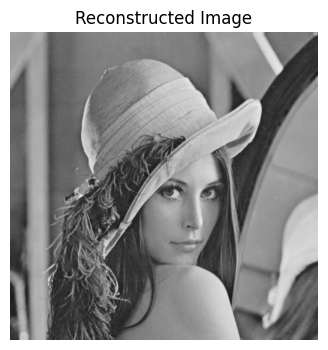

In [8]:
import matplotlib.pyplot as plt

# Display reconstructed image
w, h, maxval, pixels = read_pgm_p5("reconstructed.pgm")

plt.figure(figsize=(6,4))
plt.imshow([pixels[i*w:(i+1)*w] for i in range(h)], cmap='gray', vmin=0, vmax=255)
plt.title("Reconstructed Image")
plt.axis("off")
plt.show()


## How to Use with Your Own Image

1. Prepare a **PGM P5** grayscale image (8‑bit, maxval ≤ 255).
2. Upload it into the notebook working directory (left sidebar → Files).
3. Set `use_demo = False` and `input_pgm_path` to your filename.
4. Run the end‑to‑end cell. The result will be saved as `reconstructed.pgm`.

### Why PGM P5?
PGM (Portable GrayMap) in P5 (binary) is a simple, well‑documented raw format that's easy to parse and write without libraries. If your image is in another format (PNG/JPEG), convert it to PGM P5 externally before using this notebook.

## Notes & Extensions

- **Modeling**: This implementation uses a *static* model built from the image itself. For true streaming, use an **adaptive** model (update frequencies as you go), or a context model (e.g., based on neighboring pixels).
- **Speed**: Linear search is replaced with a binary search during decoding; for 257 symbols this is already fine. For larger alphabets, consider a Fenwick tree.
- **Range coder**: A range coder variant is often simpler and faster while being equivalent in compression performance.
- **File container**: To store compressed data with metadata (width/height/maxval), wrap the bitstream in a small custom header when saving to disk.
- **Color images**: Compress each channel independently (e.g., PPM or after converting to YCbCr).